## Minimum Cover Set and Maximum possible accuracy with Top-36 transforms

In [2]:
import json
import os
import pickle
import random
from functools import partial
from glob import glob

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as fv
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.patches as patches

from collections import defaultdict

sns.set()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)


### Helpers

In [3]:
dataset_names = [
    "imagenet_1k",
    "imagenet_1k_real",
    "imagenet_IN_plus_real",
    "imagenet_r",
    "imagenet_a",
    "imagenet_sketch",
    "objectnet",
]

model_names = ["resnet18", "resnet50", "vit32", "vgg16", "alexnet", "clip_vit_l_14"]

model_name_lookup = {
    "resnet18": "resnet18",
    "resnet50": "resnet50",
    "vit32": "vit_b_32",
    "vgg16": "vgg16",
    "alexnet": "alexnet",
    "clip_vit_l_14": "clip_vit_l_14"
}

pretty_model_names = {
    "resnet18": "ResNet-18",
    "resnet50": "ResNet-50",
    "vit32": "ViT-B/32",
    "vgg16": "VGG-16",
    "alexnet": "AlexNet",
    "clip_vit_l_14": "CLIP ViT-L/14"
}

pretty_dataset_names = {
    "imagenet_1k": "ImageNet",
    "imagenet_1k_real": "ImageNet ReaL",
    "imagenet_IN_plus_real": "ImageNet + ReaL",
    "imagenet_r": "ImageNet-R",
    "imagenet_a": "ImageNet-A",
    "imagenet_sketch": "ImageNet-Sketch",
    "objectnet": "ObjectNet",
}


### Load results

In [4]:
with open('./src/correctness_dfs.pkl', 'rb') as f:
    correctness_dfs = pickle.load(f)

## Classification Results

1. Standard 1-crop accuracy
2. Maximum possible accuracy

In [5]:
standard_accuracy = defaultdict(dict)
max_possible_accuracy = defaultdict(dict)

for dataset in dataset_names:
    for model in model_names:
        standard_accuracy[dataset][model] = 100* correctness_dfs[dataset][model].loc['LOC:1_1_Size:256'].mean()
        max_possible_accuracy[dataset][model]  = 100*np.mean(correctness_dfs[dataset][model].max(0))

In [6]:
s_acc_df = pd.DataFrame(standard_accuracy)
s_acc_df.index = [pretty_model_names[i] for i in s_acc_df.index]
s_acc_df.columns = [pretty_dataset_names[i] for i in s_acc_df.columns]
s_acc_df.round(2)

ImageNet  ImageNet ReaL  ImageNet + ReaL  ImageNet-R  \
ResNet-18         69.45          76.94            79.48       32.14   
ResNet-50         75.75          82.63            85.82       35.39   
ViT-B/32          75.75          81.89            85.22       41.29   
VGG-16            71.37          78.90            81.60       26.98   
AlexNet           56.16          62.67            64.62       21.10   
CLIP ViT-L/14     75.04          80.69            84.22       86.83   

               ImageNet-A  ImageNet-Sketch  ObjectNet  
ResNet-18            1.37            19.41      27.59  
ResNet-50            0.21            22.91      36.18  
ViT-B/32             9.64            26.83      30.89  
VGG-16               2.69            16.78      28.32  
AlexNet              1.75            10.05      14.23  
CLIP ViT-L/14       71.28            58.23      66.32

In [7]:
m_acc_df = pd.DataFrame(max_possible_accuracy)
m_acc_df.index = [pretty_model_names[i] for i in m_acc_df.index]
m_acc_df.columns = [pretty_dataset_names[i] for i in m_acc_df.columns]
m_acc_df.round(2)

ImageNet  ImageNet ReaL  ImageNet + ReaL  ImageNet-R  \
ResNet-18         95.15          97.76            98.52       66.89   
ResNet-50         96.78          98.62            99.26       68.84   
ViT-B/32          97.19          98.75            99.44       75.58   
VGG-16            95.30          97.90            98.57       60.88   
AlexNet           90.03          93.85            94.99       55.52   
CLIP ViT-L/14     96.78          98.70            99.37       99.20   

               ImageNet-A  ImageNet-Sketch  ObjectNet  
ResNet-18           58.87            43.68      71.44  
ResNet-50           66.68            47.64      76.83  
ViT-B/32            78.03            55.99      79.28  
VGG-16              58.27            39.90      71.85  
AlexNet             42.23            29.53      59.65  
CLIP ViT-L/14       98.49            89.00      93.13

## Min-Cover

In [8]:
def set_cover(subsets):
    elements = set(e for s in subsets.values() for e in s)
    covered = set()
    cover = []
    while covered != elements:
        key_, value_ = max(subsets.items(), key=lambda x: len(set(x[1]) - covered))
        cover.append(key_)
        covered |= set(value_)

    return cover

In [9]:
def get_min_cover(dataset, model):
    graph = {}
    min_cover = {}

    v = correctness_dfs[dataset][model]
    backup_graph = defaultdict(list)
    nodes_a = list(v.index)

    for n1 in tqdm(nodes_a, total=len(nodes_a)):
        backup_graph[n1].extend(list(v.loc[n1][v.loc[n1]].index))

    graph[model] = backup_graph

    for k, v in tqdm(graph.items(), total=len(graph)):
        S = [set(x) for x in list(v.values())]
        min_cover[k] = set_cover(v)

    return list(min_cover.values())

In [10]:
min_covers = defaultdict(dict)

for dataset in dataset_names:
    for model in model_names:
        min_covers[dataset][model] = get_min_cover(dataset, model)

100%|██████████| 1/1 [00:11<00:00, 11.98s/it]


### Min Cover Size

In [19]:
min_cover_counts = defaultdict(dict)

for dataset in dataset_names:
    for model in model_names:
        min_cover_counts[dataset][model] = len(min_covers[dataset][model][0])

In [23]:
mean_cover_size_df = pd.DataFrame(min_cover_counts)
mean_cover_size_df.index = [pretty_model_names[i] for i in mean_cover_size_df.index]
mean_cover_size_df.columns = [pretty_dataset_names[i] for i in mean_cover_size_df.columns]
mean_cover_size_df['Mu'] = mean_cover_size_df.mean(1).round()
mean_cover_size_df

ImageNet  ImageNet ReaL  ImageNet + ReaL  ImageNet-R  \
ResNet-18           250            201              184         278   
ResNet-50           234            178              153         271   
ViT-B/32            233            168              138         257   
VGG-16              242            201              179         289   
AlexNet             255            239              234         272   
CLIP ViT-L/14       251            197              162         114   

               ImageNet-A  ImageNet-Sketch  ObjectNet     Mu  
ResNet-18             211              269        254  235.0  
ResNet-50             214              281        259  227.0  
ViT-B/32              193              273        273  219.0  
VGG-16                222              273        259  238.0  
AlexNet               212              275        268  251.0  
CLIP ViT-L/14          93              280        212  187.0

## Top `36` performing transformations

In [29]:
top_36_accyracy = {}

for dataset in dataset_names:
    top_36_accyracy[dataset] = {}
    for model in model_names:
        top_36 = min_covers[dataset][model][0][:36]
        results = correctness_dfs[dataset][model]
        acc = 100*results.loc[top_36].max(0).mean()
        top_36_accyracy[dataset][model] = acc

In [33]:
top_36_max_acc_df = pd.DataFrame(top_36_accyracy)
top_36_max_acc_df.index = [pretty_model_names[i] for i in top_36_max_acc_df.index]
top_36_max_acc_df.columns = [pretty_dataset_names[i] for i in top_36_max_acc_df.columns]
top_36_max_acc_df.round(2)

ImageNet  ImageNet ReaL  ImageNet + ReaL  ImageNet-R  \
ResNet-18         92.08          95.97            97.25       58.85   
ResNet-50         94.46          97.36            98.55       61.42   
ViT-B/32          95.05          97.61            98.82       68.77   
VGG-16            92.30          96.08            97.27       52.86   
AlexNet           85.19          90.30            91.78       47.04   
CLIP ViT-L/14     94.19          97.32            98.55       98.60   

               ImageNet-A  ImageNet-Sketch  ObjectNet  
ResNet-18           47.48            37.91      63.08  
ResNet-50           55.68            41.71      69.60  
ViT-B/32            68.43            49.10      70.30  
VGG-16              46.69            34.34      62.94  
AlexNet             31.37            24.40      49.17  
CLIP ViT-L/14       97.16            83.77      89.59

## Visualiztion

In [51]:
def crop_at(size, slice_x, slice_y):
    def slice_crop(image, size, slice_x, slice_y):
        new_height, new_width = size, size
        width, height = image.size

        tile_size_x = width // 3
        tile_size_y = height // 3

        anchor_x = (slice_y * tile_size_x) + (tile_size_x // 2)
        anchor_y = (slice_x * tile_size_y) + (tile_size_y // 2)

        return fv.crop(
            image,
            anchor_y - (new_height // 2),
            anchor_x - (new_width // 2),
            new_height,
            new_width,
        )

    return partial(slice_crop, size=size, slice_x=slice_x, slice_y=slice_y)

def string_to_crop(text):
    size = int(text.split('Size:')[-1])
    slice_x, slice_y = text.split('LOC:')[-1].split('_')[:2]
    
    ft = transforms.Compose([transforms.Resize(size), crop_at(size, int(slice_x), int(slice_y)), transforms.CenterCrop(224)])

    return ft
    

In [52]:
def plot_top_36_transforms(sample_image, dataset, model):
    sns.set_palette("Set2")
    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 3})

    top36_transforms = min_covers[dataset][model][0][:36]
    
    _, axes = plt.subplots(6, 6, figsize=(30, 30))
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.set_title(top36_transforms[i])
        ax.imshow(string_to_crop(top36_transforms[i])(sample_image))


In [53]:
sample_image = Image.open('./test.jpg')

In [54]:
top36_transforms = min_covers["imagenet_a"]["resnet50"][0][:36]

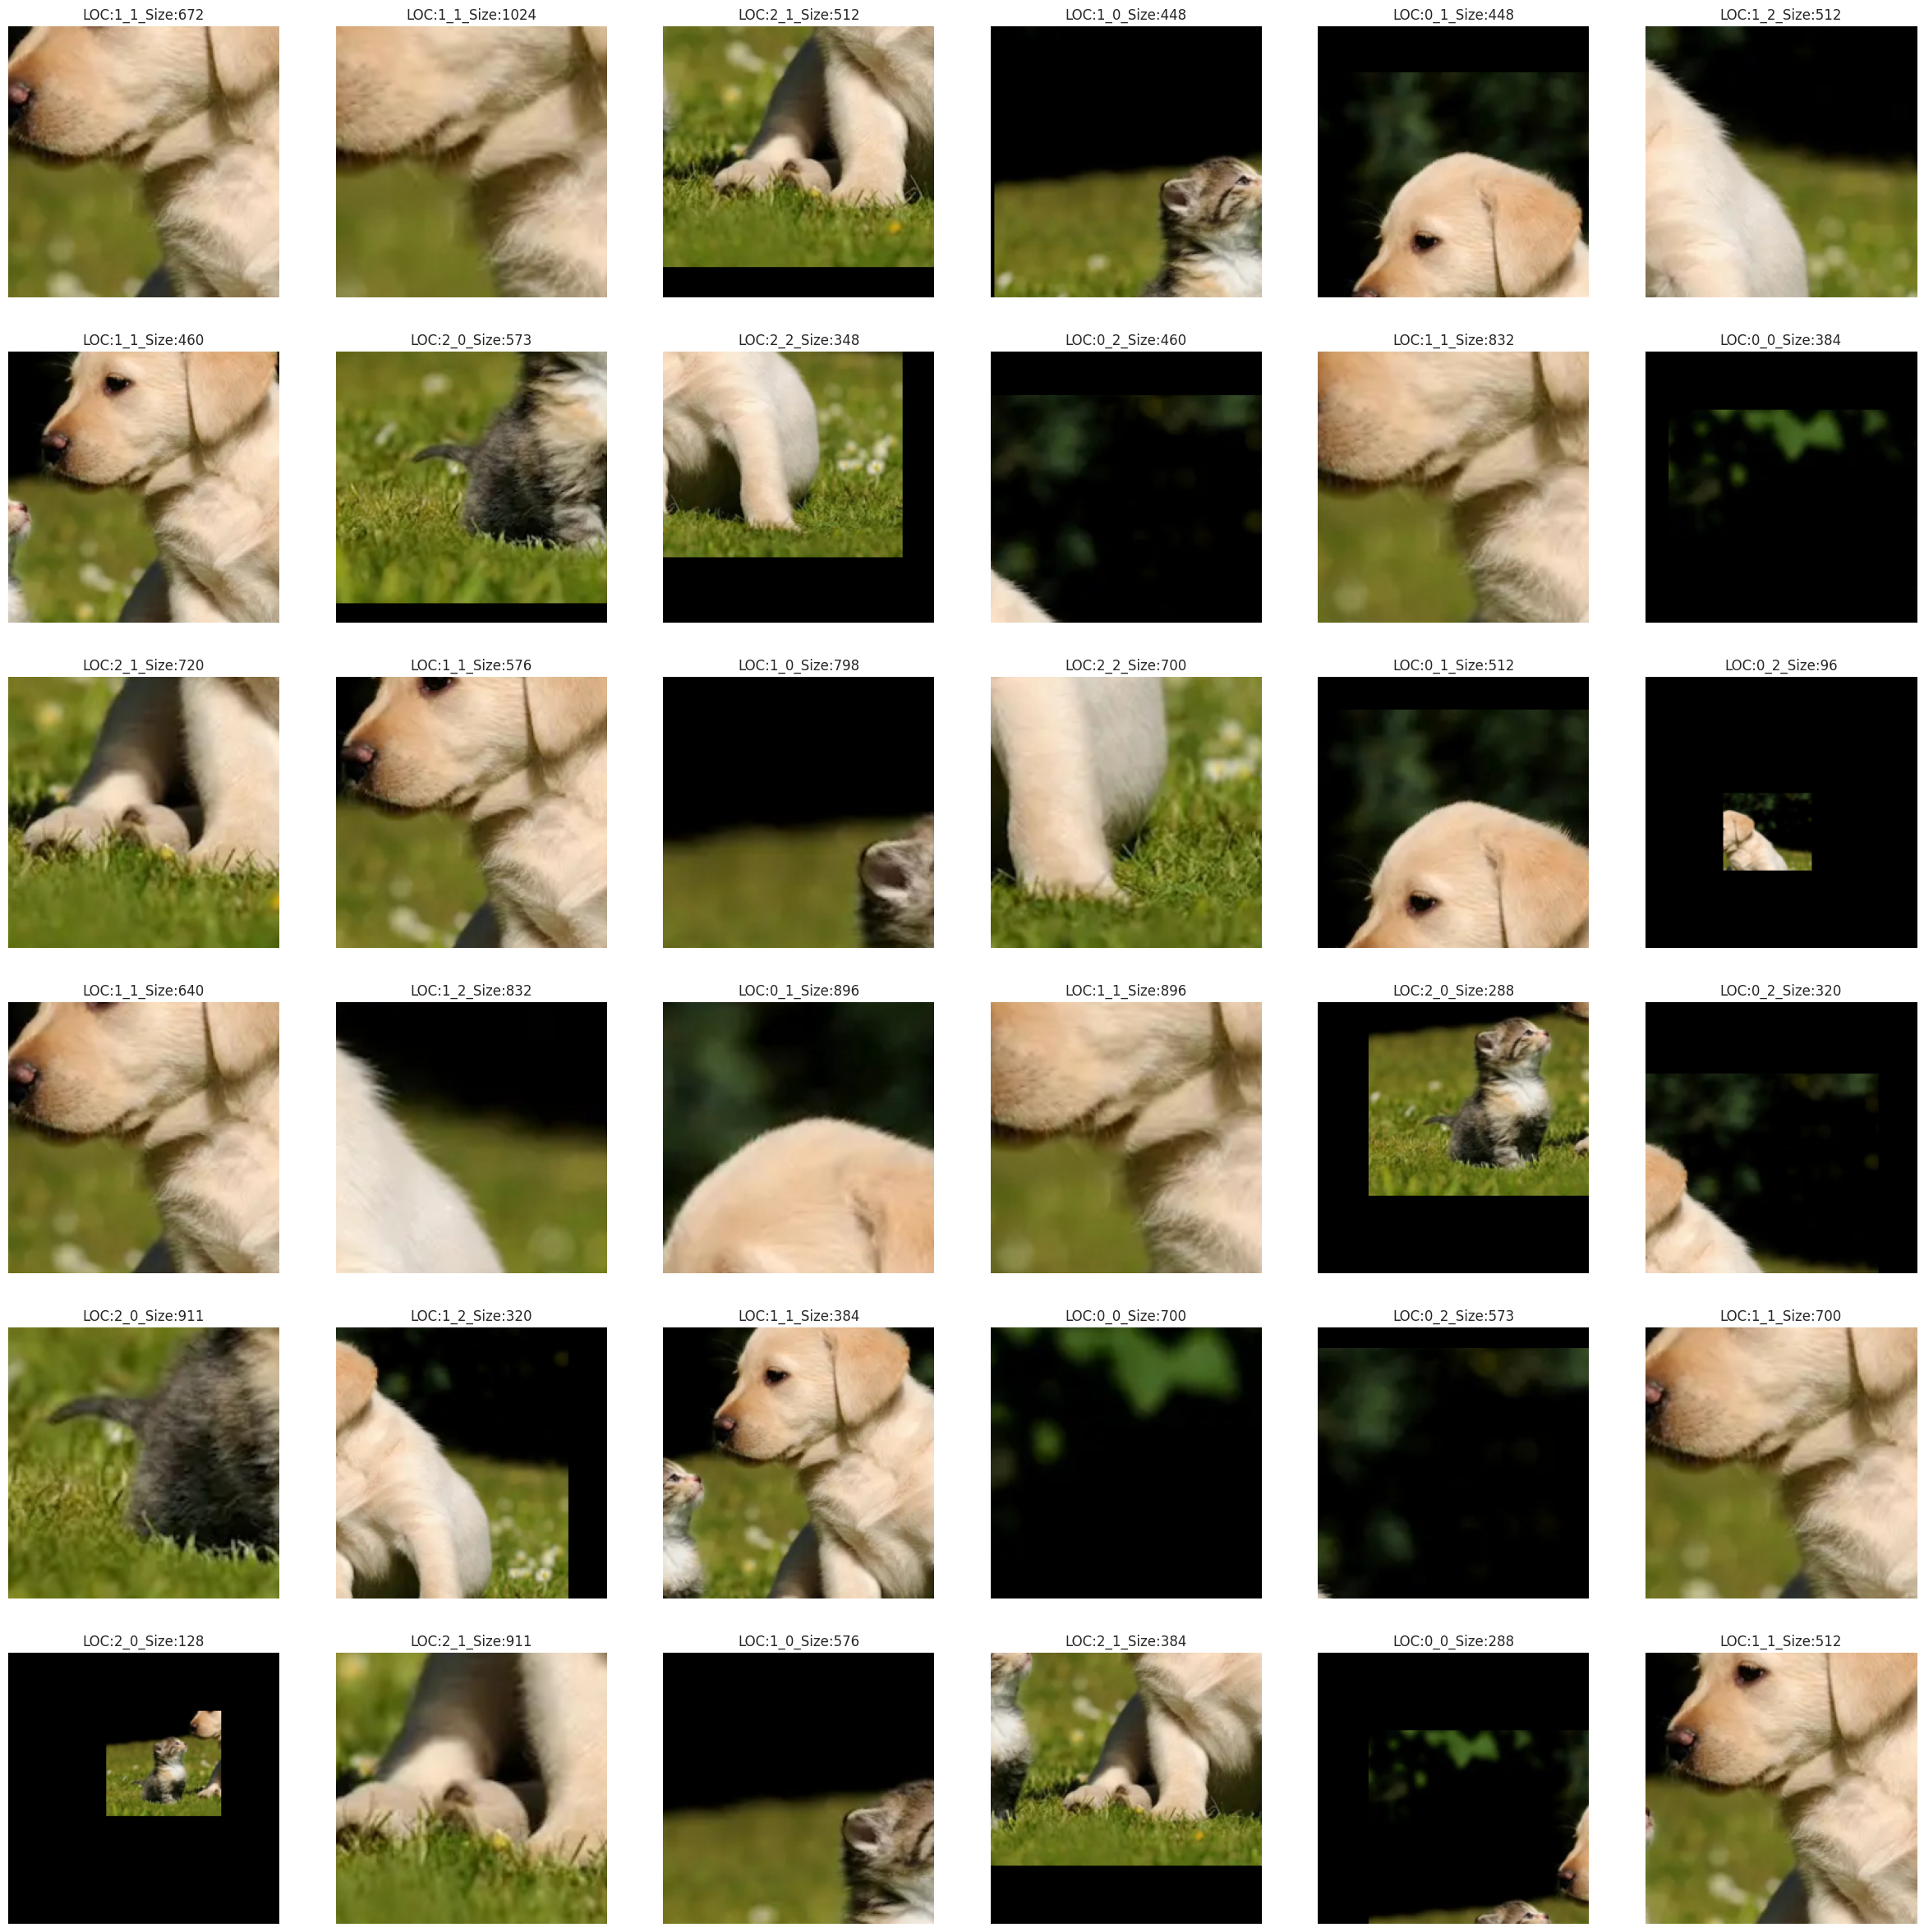

In [60]:
plot_top_36_transforms(sample_image, 'imagenet_a', 'resnet50')

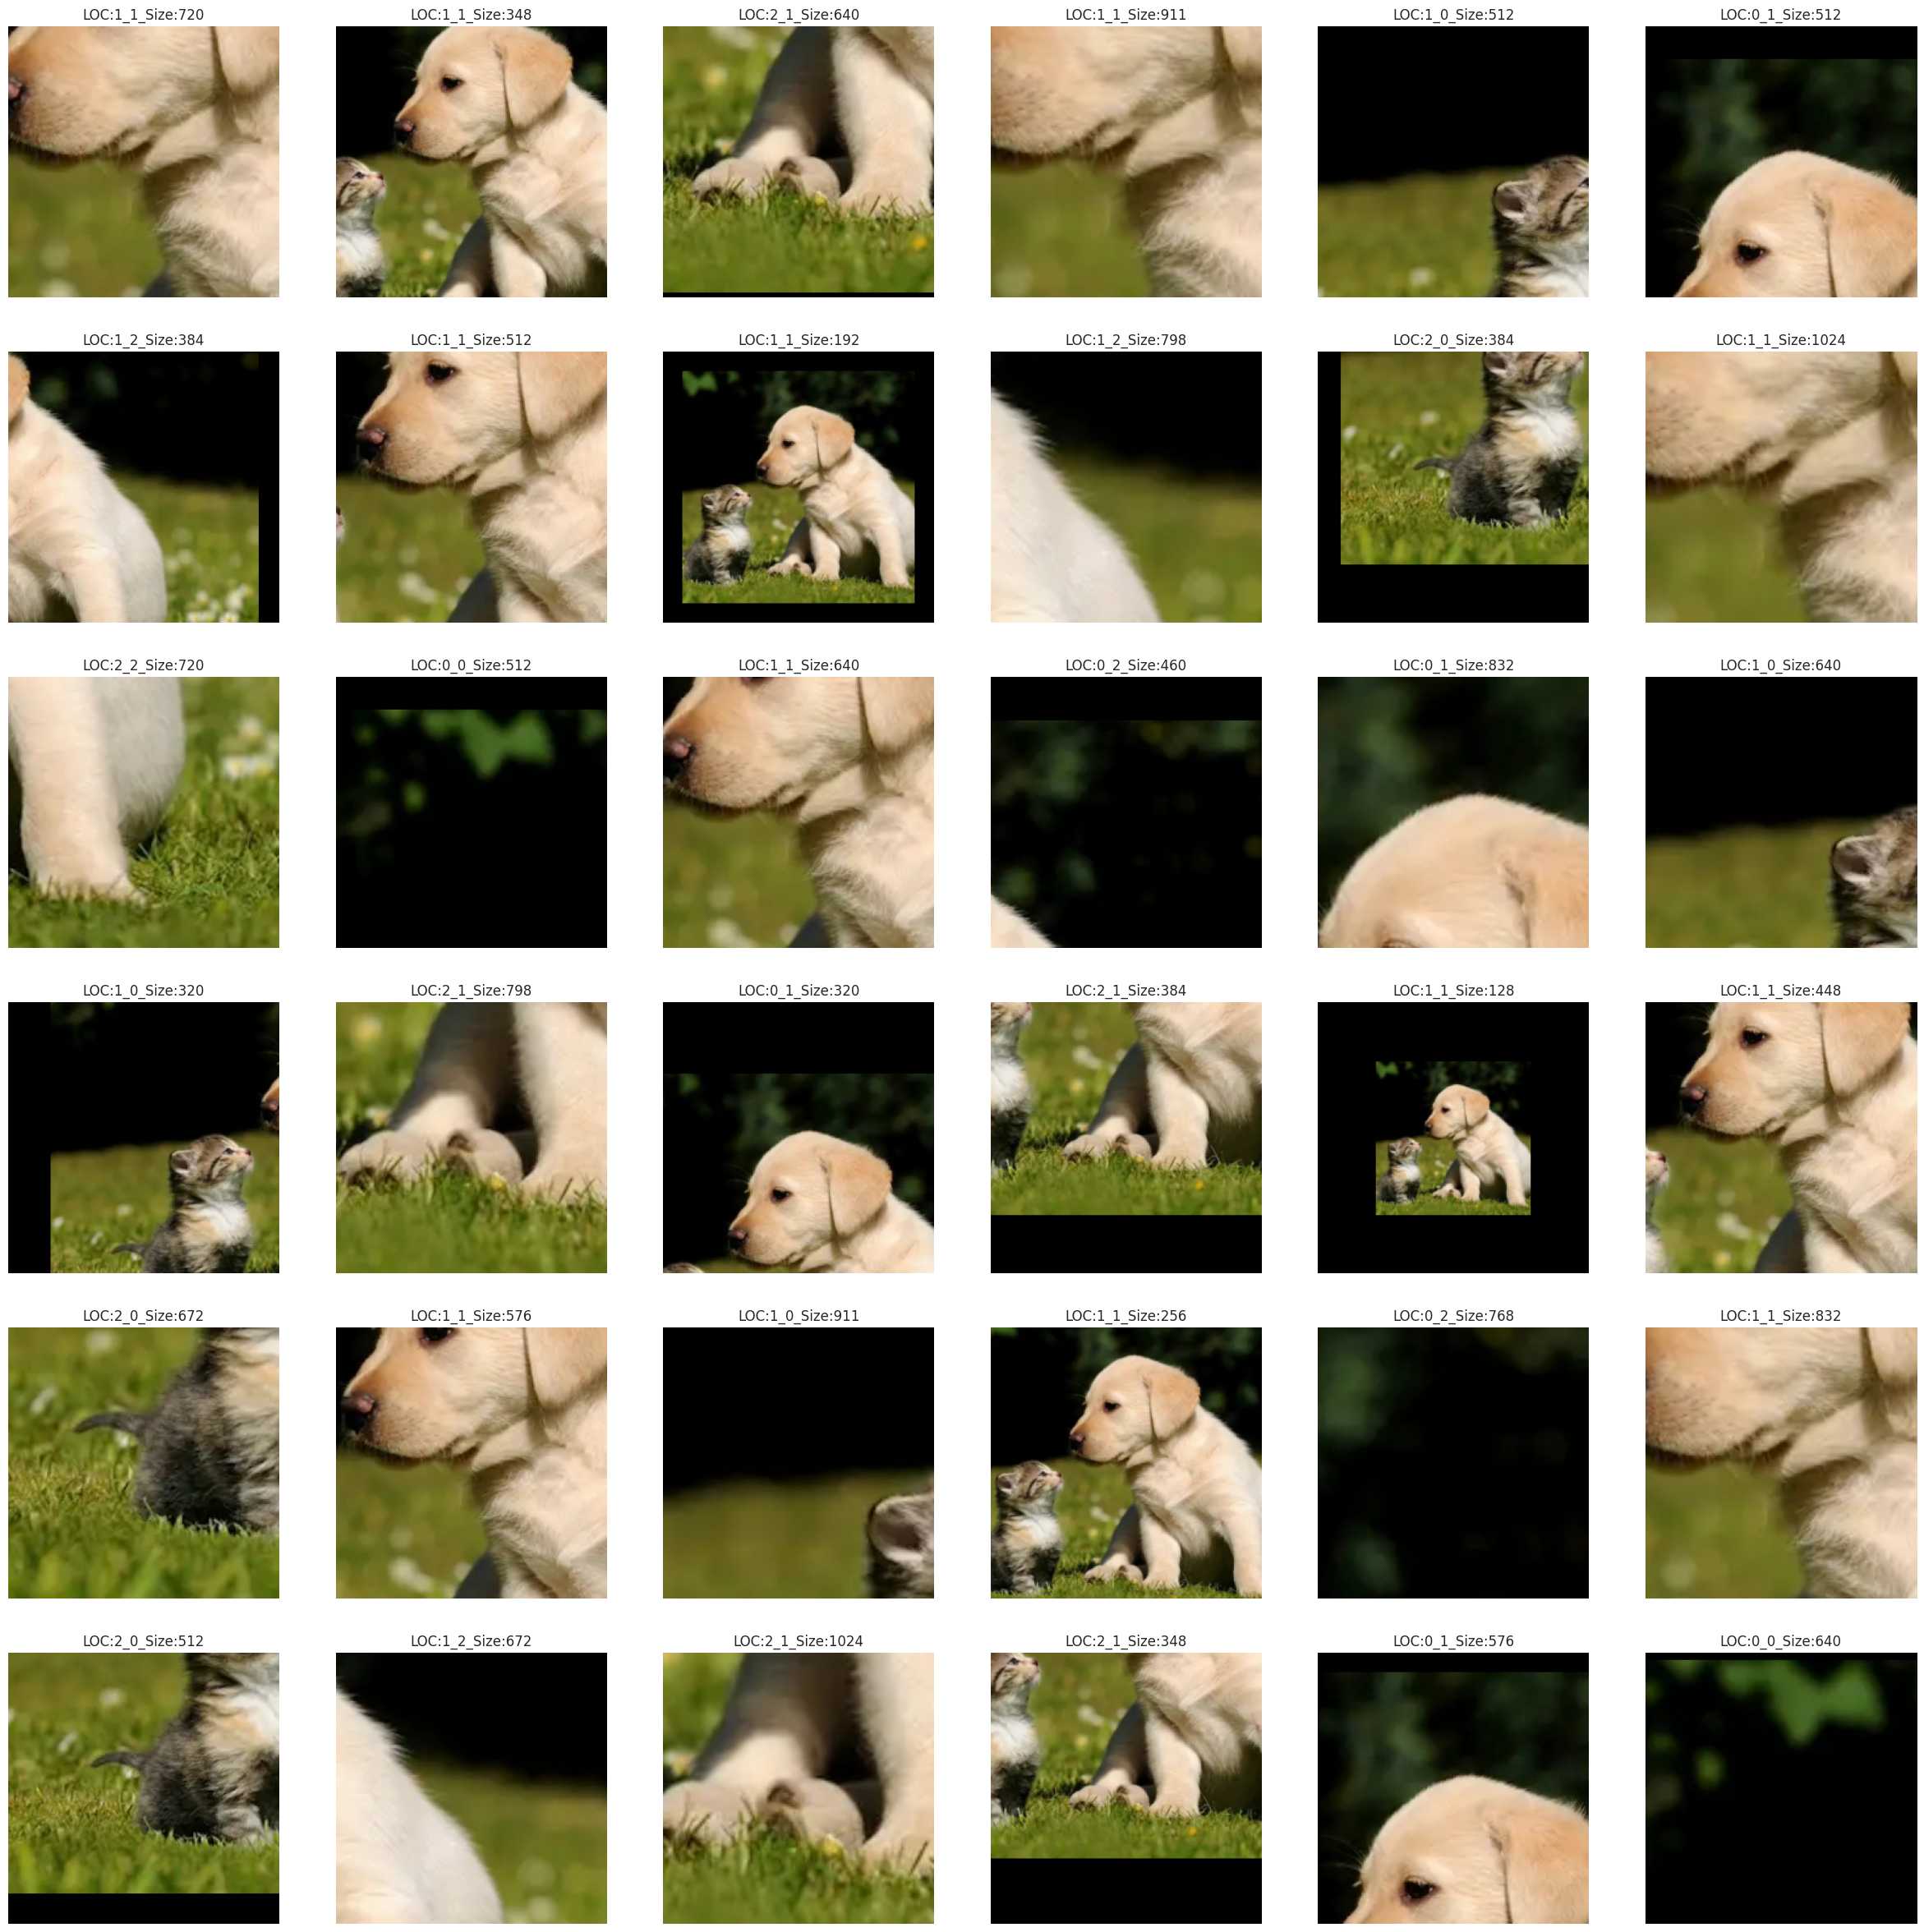

In [61]:
plot_top_36_transforms(sample_image, 'imagenet_a', 'vit32')